In [1]:
%load_ext autoreload
%autoreload 2

In [115]:
import os,sys,inspect
sys.path.insert(0,"..") 
from glob import glob
from os.path import exists, join

import matplotlib.pyplot as plt
import numpy as np
import torchvision
import os,sys,inspect
sys.path.insert(0,"..") 
from glob import glob
from os.path import exists, join
import torch
import train_utils
import argparse
import skimage.transform
import sklearn.metrics
import models, models.densenet
import datasets, datasets.xray
import torchvision
import torch.nn
import pickle
import torch.nn.functional as F
import pandas as pd

In [4]:
# !mkdir $SLURM_TMPDIR/OpenI
# !rsync ~/projects/rpp-bengioy/jpcohen/OpenI/images/NLMCXR_png.tgz $SLURM_TMPDIR/OpenI
# !tar xf $SLURM_TMPDIR/OpenI/NLMCXR_png.tgz -C $SLURM_TMPDIR/OpenI/

In [3]:
import torchvision, torchvision.transforms
transforms = torchvision.transforms.Compose([datasets.xray.XRayCenterCrop(),datasets.xray.XRayResizer(224)])

In [5]:
d_openi = datasets.xray.Openi_XrayDataset(#datadir="/lustre03/project/6008064/jpcohen/OpenI/NLMCXR_png/images/",
            datadir=os.path.join(os.getenv('SLURM_TMPDIR'), "OpenI"),
            xmlpath="/lustre03/project/6008064/jpcohen/OpenI/ecgen-radiology/",
            filter_pa=False,
            transform=transforms)

In [6]:
model = torch.load("/home/cohenjos/scratch/concept-embedding2/nihpcchexmimic_chmimic_nbgoogle-densenet121-d121-tw-lr001-rot45-tr15-sc15-seed0-best.pt")


In [7]:
feats = []
for i in range(len(d_openi)):
    out = model.features(torch.from_numpy(d_openi[i]["PA"]).unsqueeze(0).cuda())
    out = F.relu(out, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    feats.append(out.cpu().detach().numpy().reshape(-1))
feats = np.asarray(feats)

In [8]:
feats.shape

(3851, 1024)

In [9]:
import sklearn, sklearn.manifold
X_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(feats)
X_embedded.shape

(3851, 2)

In [10]:
# import umap
# reducer = umap.UMAP()
# X_embedded = reducer.fit_transform(feats)
# X_embedded.shape

In [12]:
trans = datasets.xray.XRayResizer(20)
resized_images = []
for i in range(len(d_openi)):
    resized_images.append(trans(d_openi[i]["PA"]))

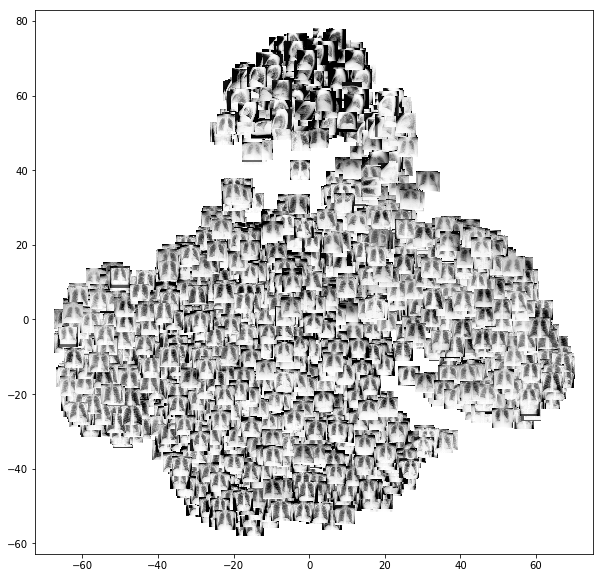

In [13]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
fig, ax = plt.subplots(figsize=(10, 10))
for item in range(X_embedded.shape[0]):
    ax.scatter(X_embedded[item,0], X_embedded[item,1])
    #plt.annotate(str(item),(X_embedded[item,0], X_embedded[item,1]))
    ab = AnnotationBbox(OffsetImage(resized_images[item][0], cmap="Greys_r"), 
                        (X_embedded[item,0], X_embedded[item,1]), frameon=False)
    ax.add_artist(ab)
    

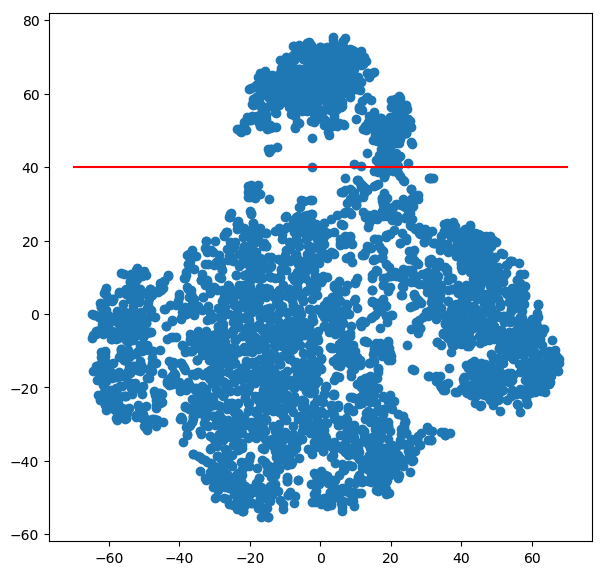

In [107]:
plt.figure(0, figsize=(7, 7), dpi=100)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
x = np.linspace(-70,70,2)
y = 0*x+40
plt.plot(x, y, '-r', label='y=2x+1');

In [104]:
border = np.arange(0,X_embedded[:,1].shape[0])[(X_embedded[:,1] > 39) & (X_embedded[:,1] < 40)]
border

array([   1, 1076, 1201, 1374, 3053, 3198, 3645, 3775])

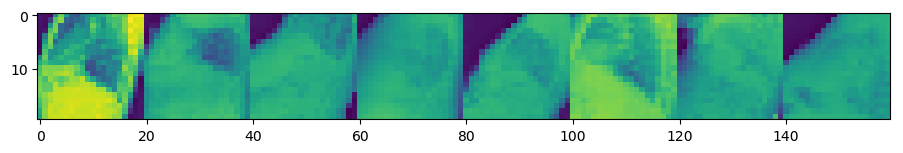

In [105]:
plt.figure(0, figsize=(11, 2), dpi=100)
images = [resized_images[image][0] for image in border]
plt.imshow(np.concatenate(images, axis=1));

In [102]:
border = np.arange(0,X_embedded[:,1].shape[0])[(X_embedded[:,1] > 36) & (X_embedded[:,1] < 39)]
border

array([  26,   70,  113,  166,  305,  362, 1307, 1715, 1811, 1936, 2002,
       2026, 2684, 3036, 3821])

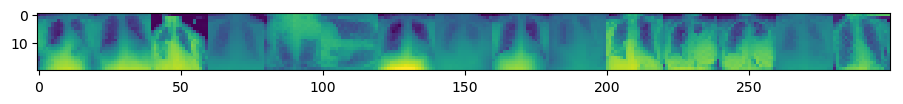

In [103]:
plt.figure(0, figsize=(11, 2), dpi=100)
images = [resized_images[image][0] for image in border]
plt.imshow(np.concatenate(images, axis=1));

In [109]:
PAs = np.arange(0,X_embedded[:,1].shape[0])[(X_embedded[:,1] < 39)]
PAs.shape

(3267,)

In [144]:
d = pd.DataFrame(d_openi.csv.imageid)

In [145]:
d["tsne-view"] = "L"

In [146]:
d["tsne-view"][PAs] = "PA"

In [147]:
d.head()

,imageid,tsne-view
0,CXR1_1_IM-0001-3001,L
1,CXR10_IM-0002-1001,L
2,CXR100_IM-0002-1001,PA
3,CXR1000_IM-0003-1001,PA
4,CXR1001_IM-0004-1001,PA


In [148]:
d = d.set_index("imageid")

In [149]:
d.to_csv("../datasets/nlmcxr_tsne_pa.csv.gz")

In [150]:
tsne_pa = pd.read_csv("../datasets/nlmcxr_tsne_pa.csv.gz", index_col="imageid")

In [151]:
tsne_pa.head()

,tsne-view
imageid,
CXR1_1_IM-0001-3001,L
CXR10_IM-0002-1001,L
CXR100_IM-0002-1001,PA
CXR1000_IM-0003-1001,PA
CXR1001_IM-0004-1001,PA


In [152]:
d_openi.csv.join(tsne_pa, on="imageid").

,uid,imageid,labels_major,labels_automatic,Accession Number,Acquisition Device Processing Code,Approval Status,Bits Allocated,Bits Stored,Body Part Examined,...,Phototimer Setting,Positioner Primary Angle,Number of Frames,Date of Secondary Capture,Secondary Capture Device ID,Secondary Capture Device Manufacturer,Secondary Capture Device Manufacturer's Model Name,Secondary Capture Device Software Versions,Time of Secondary Capture,tsne-view
0,CXR1,CXR1_1_IM-0001-3001,normal,,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L
1,CXR10,CXR10_IM-0002-1001,calcified granuloma/lung/upper lobe/right,calcified granuloma,1.572342e+15,60003,CREATED,16.0,12.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,L
2,CXR100,CXR100_IM-0002-1001,normal,,7.980739e+15,60025,CREATED,16.0,12.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
3,CXR1000,CXR1000_IM-0003-1001,opacity/lung/lingula|opacity/lung/upper lobe/r...,atelectases|atelectasis|mass lesion|opacity|ribs,8.124496e+15,60003,CREATED,16.0,12.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
4,CXR1001,CXR1001_IM-0004-1001,fibrosis/diffuse|markings/lung/bilateral/inter...,diffuse fibrosis|fibrosis|pulmonary fibrosis,2.252700e+15,NaN,NaN,16.0,12.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
5,CXR1002,CXR1002_IM-0004-1001,mastectomy/left,mastectomies|mastectomy|surgery,2.388085e+15,60025,CREATED,16.0,12.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
6,CXR1003,CXR1003_IM-0005-2002,"bone diseases, metabolic/spine|calcified granu...",atelectases|atelectasis|calcified granuloma|hi...,1.217769e+15,NaN,NaN,16.0,15.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
7,CXR1004,CXR1004_IM-0005-1001,"aorta/tortuous|catheters, indwelling|shoulder/...",degenerative change,1.752679e+15,1,NaN,16.0,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
8,CXR1005,CXR1005_IM-0006-1001,normal,,1.241830e+15,NaN,NaN,16.0,15.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
9,CXR1006,CXR1006_IM-0007-1001,normal,,2.128976e+15,NaN,NaN,16.0,15.0,CHEST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PA
